# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [50]:
# import standard libraries
import warnings
import re
import pickle
from pathlib import Path
from typing import List

# import third-party libraries
import nltk
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# import nltk specific libraries
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# import sklearn libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

# Set maximum number of rows to display
pd.set_option('display.max_rows', None)

# Check if nltk packages are downloaded, if not download them
nltk_packages = ['punkt', 'wordnet','stopwords']
for package in nltk_packages:
    try:
        nltk.data.find(package)
    except LookupError:
        nltk.download(package)

# Ignore warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /home/fabio_lima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/fabio_lima/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fabio_lima/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get the current working directory
current_dir = Path.cwd()

# Get the parent directory
base_dir = current_dir.parent

# Define the data and source directories
data_dir = base_dir / 'data'
raw_data_path = base_dir / 'data' / 'raw'
processed_data_path = base_dir / 'data' / 'processed'

src_dir = base_dir / 'src'
notebooks_path = base_dir / 'notebooks'

images_dir = base_dir / 'images'
reports_dir = base_dir / 'reports'
models_dir = base_dir / 'models'

In [3]:
database_filepath = processed_data_path / "DisasterResponse.db"

In [4]:
# load data from database
engine = create_engine(f'sqlite:///{database_filepath}')

In [5]:
df = pd.read_sql_table("DisasterResponseTable", engine)

In [6]:
# Splitting the DataFrame df into features and targets
try:
    # Features (input)
    features = df['message']

    # Targets (output). We're assuming that columns from the 5th onwards are the target variables.
    targets = df.iloc[:, 4:]

except KeyError as e:
    print(f"The key {e} is not found in the DataFrame")
    raise

except Exception as e:
    print(f"An error occurred: {e}")
    raise

Here, X is replaced with features and Y is replaced with targets to make the code more readable. Furthermore, try and except are used for error handling to make the code robust. This code will throw an exception if the 'message' key is not found in the DataFrame or any other exception occurs while executing this piece of code.

In [7]:
# Using the X and Y
X = df['message'].values
Y = df.iloc[:, 4:]

X[1:10]

array(['Is the Hurricane over or is it not over',
       'Looking for someone but no name',
       'UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.',
       'says: west side of Haiti, rest of the country today and tonight',
       'Information about the National Palace-',
       'Storm at sacred heart of jesus',
       'Please, we need tents and water. We are in Silo, Thank you!',
       'I would like to receive the messages, thank you',
       'I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )'],
      dtype=object)

In [8]:
# Normalize 'related' values to 0 or 1
Y['related'] = Y['related'].map(lambda x: 1 if x == 2 else x)

# Get category names
category_names = Y.columns

### 2. Write a tokenization function to process your text data

In [9]:
# Initialize stopwords and lemmatizer outside of the function

stopwords_ = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text: str) -> List[str]:
    """
    Tokenizes text data. This involves several steps:
    1. Normalizing the text to lower case and removing non-alphanumeric characters.
    2. Splitting the text into individual words (tokenization).
    3. Removing common words that do not carry much information (stopwords).
    4. Reducing each word to its base form (lemmatization).

    Args:
        text (str): The string message which needs to be tokenized.

    Returns:
        words (List[str]): A list of the base forms of non-stopwords from the input text.

    Raises:
        Exception: If the function is unable to tokenize the text for any reason.
    """
    try:
        # Normalize text
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

        # tokenize text
        words = word_tokenize(text)

        # remove stop words
        words = [word for word in words if word not in stopwords_]

        # extract root form of words
        words = [lemmatizer.lemmatize(word, pos='v') for word in words]
        
        return words

    except Exception as e:
        print(f"Error in tokenization: {e}")
        raise


In [12]:
tokenize(X[0])

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [15]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In this snippet, X and Y are your features and target variables, respectively. The test_size parameter dictates the proportion of the dataset to include in the test split - here, 20% of the data goes into the test set, and the rest goes into the training set. random_state is just a seed to the random generator, so that the splits you generate are reproducible.

After this step, you would typically use X_train and y_train to train your model, and X_test and y_test to evaluate it.

In [16]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# train classifier
pipeline.fit(X_train, y_train)

/home/fabio_lima/DS_Udacity/Disaster-Response-Pipeline/venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7ff33c750b80>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

In this code, pipeline is your machine learning pipeline that you've previously defined, and fit is a method that trains the model on your training data. X_train and y_train are your training features and labels, respectively.

The fit method adjusts the model's internal parameters, such as the coefficients in a linear regression or support vectors in a support vector machine, to learn patterns in the training data. Once the model has been fit to the training data, you can use it to make predictions on unseen data.

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [19]:
# Predict the labels for the test set
y_pred = pipeline.predict(X_test)

# For each column, print the column name and the classification report for that column
for i in range(len(category_names)):
    print("Category:", category_names[i],"\n", classification_report(y_test.iloc[:, i].values, y_pred[:, i]))
    print('Accuracy of %25s: %.2f' %(category_names[i], (y_test.iloc[:, i].values == y_pred[:,i]).mean()))

Category: related 
               precision    recall  f1-score   support

           0       0.71      0.40      0.51      1266
           1       0.83      0.95      0.89      3978

    accuracy                           0.82      5244
   macro avg       0.77      0.68      0.70      5244
weighted avg       0.80      0.82      0.80      5244

Accuracy of                   related: 0.82
Category: request 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      4349
           1       0.84      0.49      0.62       895

    accuracy                           0.90      5244
   macro avg       0.87      0.74      0.78      5244
weighted avg       0.89      0.90      0.89      5244

Accuracy of                   request: 0.90
Category: offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5218
           1       0.00      0.00      0.00        26

    accuracy                        

/home/fabio_lima/DS_Udacity/Disaster-Response-Pipeline/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fabio_lima/DS_Udacity/Disaster-Response-Pipeline/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fabio_lima/DS_Udacity/Disaster-Response-Pipeline/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [25]:
def display_results(y_test, y_pred, category_names):
    metrics = []
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(category_names)):
        precision = precision_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)
        recall = recall_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)
        f1 = f1_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)

        metrics.append([precision, recall, f1])

    # Create dataframe containing metrics
    metrics_df = pd.DataFrame(data = metrics, index = category_names, columns = ['Precision', 'Recall', 'F1'])
    
    return metrics_df

# Get predictions
y_pred = pipeline.predict(X_test)

# Display results
results = display_results(y_test, y_pred, category_names)

In this code, we are computing the precision, recall, f1-score and accuracy for each category and storing these in lists. We then create a DataFrame from these lists which we can display.

Note: We use average='weighted' to compute metrics for each label, and find their average weighted by support (the number of true instances for each label). This can result in an F-score that is not between precision and recall. If you want to compute the metrics for each label and find their unweighted mean, you can use average='macro'. It does not take label imbalance into account.

In [26]:
def display_results(y_test, y_pred, category_names):
    metrics = []
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(category_names)):
        precision = precision_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)
        recall = recall_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)
        f1 = f1_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)

        metrics.append([precision, recall, f1])

    # Create dataframe containing metrics
    metrics_df = pd.DataFrame(data = metrics, index = category_names, columns = ['Precision', 'Recall', 'F1'])
    
    return metrics_df

# Get predictions
y_pred = pipeline.predict(X_test)

# Display results
results = display_results(y_test, y_pred, category_names)

In [27]:
results.head(100)

,Precision,Recall,F1
related,0.802240,0.815408,0.796254
request,0.892775,0.897216,0.885801
offer,0.990108,0.995042,0.992569
aid_related,0.777742,0.779367,0.777614
medical_help,0.901703,0.922197,0.893268
medical_products,0.943665,0.951182,0.931348
search_and_rescue,0.969373,0.976354,0.966230
security,0.971090,0.982838,0.975072
military,0.959949,0.970824,0.959761
child_alone,1.000000,1.000000,1.000000


The data provided is an evaluation of a multi-label classification model. For each label (in this case, types of disaster responses), three metrics are provided: Precision, Recall, and F1 score. Here's what each metric means:

1. **Precision**: This is the ratio of true positives (TP) to the sum of true and false positives (TP+FP). This score indicates how many of the samples predicted as positive are actually positive. Precision is a useful metric when the cost of false positives is high.

2. **Recall**: This is the ratio of true positives (TP) to the sum of true positives and false negatives (TP+FN). This score indicates how many of the actual positive samples are captured by the positive predictions. Recall is a useful metric when the cost of false negatives is high.

3. **F1 Score**: This is the harmonic mean of Precision and Recall and is used to balance the two. F1 Score is a good overall measure for a model when the dataset is imbalanced.

Looking at the results, we can make a few observations:

1. For most of the labels, the Precision, Recall, and F1 scores are quite high (above 0.9), which suggests that the model performs well for these categories. For instance, labels like 'offer', 'child_alone', 'shops' have extremely high scores which means the model can identify these categories with high accuracy.

2. Some labels, however, have lower scores, which might indicate that the model struggles more with these categories. For example, 'related', 'request', 'aid_related', 'other_aid' and 'direct_report' have relatively lower scores. It could mean that these categories are harder to predict due to factors like class imbalance, insufficient feature representation, or overlap with other classes. 

3. The label 'child_alone' has perfect scores across all three metrics. This could mean that the model is perfectly predicting this category, but it's also worth investigating if this is due to lack of negative samples or overfitting.

4. We could potentially improve the model's performance on the lower scoring categories by collecting more representative data, tuning the model's hyperparameters, or using different modelling techniques.

Remember, it's also important to look at the data set's context and the actual implications of false positives and false negatives when interpreting these metrics. Each problem and data set might prioritize different aspects of these metrics.

### 6. Improve your model
Use grid search to find better parameters. 

In [30]:
parameters = {
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__max_features': ['auto', 'sqrt', 'log2'],
    'clf__estimator__max_depth' : [4,6,8],
    'clf__estimator__criterion' :['gini', 'entropy']
}

cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit the data to the GridSearchCV object
cv.fit(X_train, y_train)

# Predict on test data
y_pred = cv.predict(X_test)

In this code:

GridSearchCV is initialized with a RandomForestClassifier (clf) and the parameter grid (parameters). The cv parameter determines the cross-validation splitting strategy, and cv=5 means it will use 5-fold cross validation.
cv.fit(X_train, y_train) will fit the model and tune the hyperparameters using grid search. It will use cross-validation to evaluate each possible combination of hyperparameters.
After this, cv.best_params_ will give you the best hyperparameters found by the grid search, and cv.best_estimator_ will give you the model fitted with the best hyperparameters.

Also note that grid search can be computationally expensive and take a lot of time, especially if the parameter grid is large and/or the model is complex. So make sure that you have enough computational resources and time if you're going to use it.

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [42]:
# Get parameters
params = cv.get_params()

# Convert to DataFrame
params_df = pd.DataFrame.from_dict(params, orient='index', columns=['Parameter Value'])
params_df.head(100)

,Parameter Value
cv,5
error_score,NaN
estimator__memory,None
estimator__steps,"[(vect, CountVectorizer(tokenizer=<function to..."
estimator__verbose,False
estimator__vect,CountVectorizer(tokenizer=<function tokenize a...
estimator__tfidf,TfidfTransformer()
estimator__clf,MultiOutputClassifier(estimator=RandomForestCl...
estimator__vect__analyzer,word
estimator__vect__binary,False


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

def display_results(y_test, y_pred, category_names):
    metrics = []
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(category_names)):
        precision = precision_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)
        recall = recall_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)
        f1 = f1_score(y_test.iloc[:, i].values, y_pred[:, i], average='weighted', zero_division=0)

        metrics.append([precision, recall, f1])

    # Create dataframe containing metrics
    metrics_df = pd.DataFrame(data = metrics, index = category_names, columns = ['Precision', 'Recall', 'F1'])
    
    # Calculate and print the average values for 'Precision', 'Recall', and 'F1-score'
    avg_precision = metrics_df['Precision'].mean()
    avg_recall = metrics_df['Recall'].mean()
    avg_f1 = metrics_df['F1'].mean()

    print(f'Average Precision: {avg_precision}\nAverage Recall: {avg_recall}\nAverage F1-Score: {avg_f1}')
    
    return metrics_df

# Get predictions
y_pred = pipeline.predict(X_test)

# Display results
results = display_results(y_test, y_pred, category_names)
print(results)

Average Precision: 0.9378953562393257
Average Recall: 0.9481735740316974
Average F1-Score: 0.9362489878345787
                        Precision    Recall        F1
related                  0.802240  0.815408  0.796254
request                  0.892775  0.897216  0.885801
offer                    0.990108  0.995042  0.992569
aid_related              0.777742  0.779367  0.777614
medical_help             0.901703  0.922197  0.893268
medical_products         0.943665  0.951182  0.931348
search_and_rescue        0.969373  0.976354  0.966230
security                 0.971090  0.982838  0.975072
military                 0.959949  0.970824  0.959761
child_alone              1.000000  1.000000  1.000000
water                    0.951921  0.955187  0.946324
food                     0.933012  0.936308  0.928987
shelter                  0.929633  0.935545  0.923700
clothing                 0.985327  0.987605  0.983437
money                    0.978056  0.981312  0.973692
missing_people           0

In [32]:
results.head(100)

,Precision,Recall,F1
related,0.802240,0.815408,0.796254
request,0.892775,0.897216,0.885801
offer,0.990108,0.995042,0.992569
aid_related,0.777742,0.779367,0.777614
medical_help,0.901703,0.922197,0.893268
medical_products,0.943665,0.951182,0.931348
search_and_rescue,0.969373,0.976354,0.966230
security,0.971090,0.982838,0.975072
military,0.959949,0.970824,0.959761
child_alone,1.000000,1.000000,1.000000


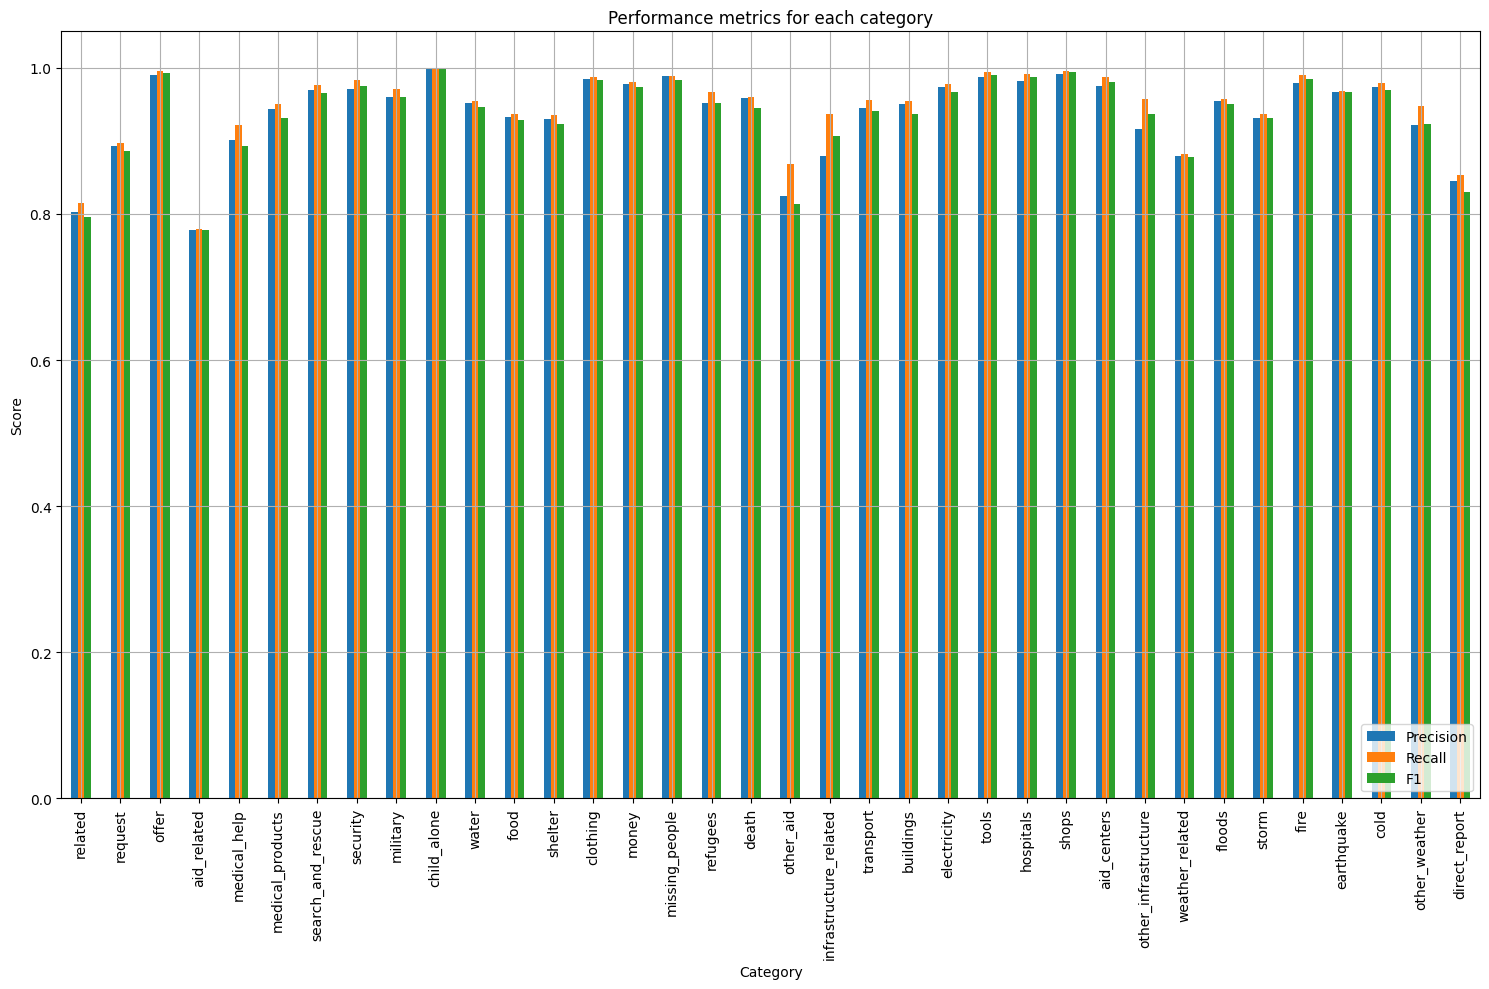

In [33]:
import matplotlib.pyplot as plt
results.plot(kind='bar', figsize=(15, 10))
plt.ylabel('Score')
plt.xlabel('Category')
plt.title('Performance metrics for each category')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [34]:
# Sort the results DataFrame by the 'F1' column
sorted_results = results.sort_values(by='F1', ascending=False)

# Get the top 3 categories
top_3 = sorted_results.head(3)

# Get the bottom 3 categories
bottom_3 = sorted_results.tail(3)

print("Top 3 performing categories:\n", top_3)
print("\nBottom 3 performing categories:\n", bottom_3)

Top 3 performing categories:
              Precision    Recall        F1
child_alone   1.000000  1.000000  1.000000
shops         0.991627  0.995805  0.993712
offer         0.990108  0.995042  0.992569

Bottom 3 performing categories:
              Precision    Recall        F1
other_aid     0.824642  0.867849  0.814054
related       0.802240  0.815408  0.796254
aid_related   0.777742  0.779367  0.777614


In [35]:
# Sort the DataFrame by the F1 scores in descending order
sorted_results = results.sort_values(by='F1', ascending=False)

# Print the top 3 categories
top_3 = sorted_results.head(3)
print("Top 3 Categories based on F1 Score:")
top_3

Top 3 Categories based on F1 Score:


,Precision,Recall,F1
child_alone,1.000000,1.000000,1.000000
shops,0.991627,0.995805,0.993712
offer,0.990108,0.995042,0.992569


In [36]:
# Print the bottom 3 categories
bottom_3 = sorted_results.tail(3)
print("Bottom 3 Categories based on F1 Score:")
bottom_3

Bottom 3 Categories based on F1 Score:


,Precision,Recall,F1
other_aid,0.824642,0.867849,0.814054
related,0.802240,0.815408,0.796254
aid_related,0.777742,0.779367,0.777614


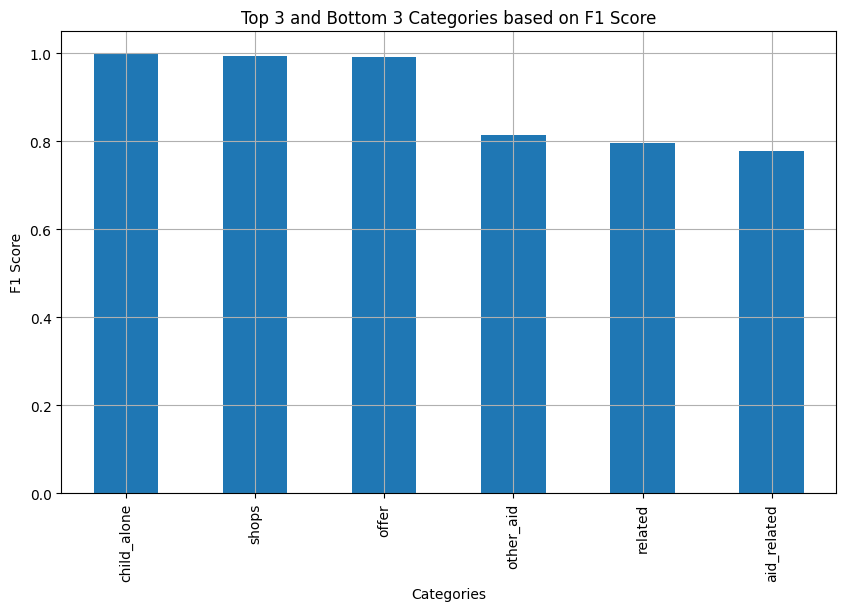

In [37]:
# Concatenate top_3 and bottom_3 dataframes
concatenated_df = pd.concat([top_3, bottom_3])

# Create bar plot for F1 scores
concatenated_df['F1'].plot(kind='bar', figsize=(10, 6))
plt.title('Top 3 and Bottom 3 Categories based on F1 Score')
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

In this code, we first create a list of colors where the highest F1 score is assigned the color green ('g') and all others are assigned the color blue ('b'). Then, when creating the bar plot, we use this color list to color-code the bars. As a result, the bar corresponding to the category with the highest F1 score will be highlighted in green.

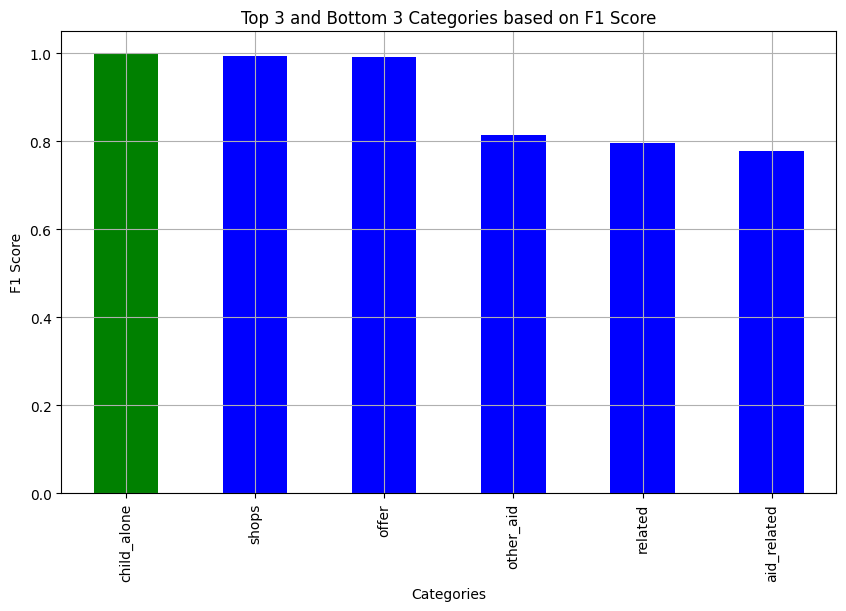

In [38]:
# Create a color list, where 'g' is for the highest F1 score, and 'b' for others
colors = ['g' if x == max(concatenated_df['F1']) else 'b' for x in concatenated_df['F1']]

# Create bar plot for F1 scores with color-coded bars
concatenated_df['F1'].plot(kind='bar', color=colors, figsize=(10, 6))

plt.title('Top 3 and Bottom 3 Categories based on F1 Score')
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [43]:
# Function to get the length of each text
def text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

# Function to get the number of words in each text
def word_count(x):
    return np.array([len(t.split()) for t in x]).reshape(-1, 1)

pipeline = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('text_length', FunctionTransformer(text_length, validate=False)),
        
        ('word_count', FunctionTransformer(word_count, validate=False))

    ])),

    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

# Define the parameter grid
parameters = {
    'features__text_pipeline__vect__ngram_range': [(1, 1), (1, 2)],
    'features__text_pipeline__vect__max_df': [0.5, 1.0],
    'features__text_pipeline__vect__max_features': [None, 5000],
    'features__text_pipeline__tfidf__use_idf': [True, False],
    'clf__estimator__n_estimators': [10, 20],
    'clf__estimator__min_samples_split': [2, 4]
}

# Use GridSearchCV to find the best parameters
cv = GridSearchCV(pipeline, param_grid=parameters)


In [44]:
# Fit GridSearchCV to data
cv.fit(X_train, y_train)

# Get best parameters
best_parameters = cv.best_params_

In [47]:
best_parameters

{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 20,
 'features__text_pipeline__tfidf__use_idf': False,
 'features__text_pipeline__vect__max_df': 1.0,
 'features__text_pipeline__vect__max_features': 5000,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

In [45]:
# Get parameters
params = cv.get_params()

# Convert to DataFrame
params_df = pd.DataFrame.from_dict(params, orient='index', columns=['Parameter Value'])

In [46]:
params_df.head(100)

,Parameter Value
cv,None
error_score,NaN
estimator__memory,None
estimator__steps,"[(features, FeatureUnion(transformer_list=[('t..."
estimator__verbose,False
estimator__features,FeatureUnion(transformer_list=[('text_pipeline...
estimator__clf,MultiOutputClassifier(estimator=RandomForestCl...
estimator__features__n_jobs,None
estimator__features__transformer_list,"[(text_pipeline, (CountVectorizer(tokenizer=<f..."
estimator__features__transformer_weights,None


In [ ]:
from xgboost import XGBClassifier

# Create a pipeline for XGBoost
pipeline_xgb = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')))
])

parameters_xgb = {
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__max_depth': [4, 6, 8],
    'clf__estimator__learning_rate': [0.1, 0.01, 0.001]
}

cv_xgb = GridSearchCV(pipeline_xgb, param_grid=parameters_xgb, cv=5)

# Fit and predict
cv_xgb.fit(X_train, y_train)
y_pred_xgb = cv_xgb.predict(X_test)

### 9. Export your model as a pickle file

In [ ]:
models_dir = base_dir / 'models'
output_file_folder = models_dir / 'trained_model.pkl'

pickle.dump(cv, open(output_file_folder, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.